In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib
from math import pi, cos, sin
import numpy as np
import cv2 as cv
import pandas as pd
import glob
import h5py
import time
# from joblib import Parallel, delayed
from matplotlib.pyplot import cm
from numpy.linalg import inv
import scipy.linalg as la
from matplotlib import patches
import random
cv.__version__

'4.5.1'

In [3]:
# checkerboard dimensions
nrows=6
ncols=8
# photo dimensions
xmax=9054
ymax=6336

In [4]:
def myCornerHarris(src, block_size=5, aperture_size=3, k=0.0):
    h,w=src.shape
    dst=np.zeros((h,w))
    scale = 1.0/(1<<((aperture_size-1)*block_size))
    Dx=cv.Sobel(src, cv.CV_64F, 1, 0, ksize=aperture_size, scale=scale, delta=0, borderType=cv.BORDER_DEFAULT)
    Dy=cv.Sobel(src, cv.CV_64F, 0, 1, ksize=aperture_size, scale=scale, delta=0, borderType=cv.BORDER_DEFAULT)
    cov=np.zeros((h,w,cv.CV_32FC3))
    for i in range(h):
        for j in range(w):
            cov[i,j,0]=Dx[i,j]*Dx[i,j]
            cov[i,j,1]=Dx[i,j]*Dy[i,j]
            cov[i,j,2]=Dy[i,j]*Dy[i,j]
    cov = cv.boxFilter(cov, cov.shape[2], (block_size, block_size), cv.BORDER_DEFAULT) 
    for i in range(h):
        for j in range(w):
            dst[i,j]=cov[i,j,0]*cov[i,j,2]-cov[i,j,1]*cov[i,j,1]-k*(cov[i,j,0]+cov[i,j,2])**2
    return dst, cov

In [5]:
def return_blur_param(images, imgpoints, njobs, ijob, outfilename):
    nimages=int((len(images)+1)/njobs)
    istart=ijob*nimages
    if ijob<njobs-1:
        istop=(ijob+1)*nimages
    else:
        istop=len(images)
    blurvars=[]
    imgfilenames=[]
    cropsvars=[]
    imgpoints2=[]
    f = h5py.File(f'{outfilename}_{ijob}.h5', 'w')
    for i in range(istart, istop):
        blurvar, crops = return_blurry(images[i].decode(), imgpoints[i])
        print(images[i].decode())
        blurvars.append(blurvar)
        imgfilenames.append(images[i].decode())
        imgpoints2.append(imgpoints[i])
        cropsvars.append(crops)
    dt = h5py.special_dtype(vlen=bytes)
    f.create_dataset('images', data=imgfilenames, dtype=dt)
    f.create_dataset('imgpoints', data=imgpoints2)
    f.create_dataset('cropsvars', data=cropsvars)
    f.create_dataset('blurvars', data=blurvars)
    f.close()

In [6]:
def find_corner_cov(img, point, block_size, aperture_size):
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    gray = np.float32(gray)
    mydst,mycov = myCornerHarris(gray, block_size, aperture_size, 0.01)
    print(point)
    i,j=np.rint(point[0]), np.rint(point[1])
    cov=np.array(([mycov[i,j,0], mycov[i,j,1]], [mycov[i,j,1], mycov[i,j,2]]))
    invcov=inv(cov)
    eigval,eigvec = la.eig(invcov)
    print(np.sqrt(eigval), angle)
    return cov, eigval, eigvec

In [7]:
def find_all_corner_covs(imgfile, imgpoint, block_size, aperture_size):
    img = cv.imread(imgfile)
    delX=(max(imgpoint[:,0])-min(imgpoint[:,0]))/ncols
    delY=(max(imgpoint[:,1])-min(imgpoint[:,1]))/nrows
    crop_x2=int(max(imgpoint[:,0])+delX)
    crop_x1=int(min(imgpoint[:,0])-delX)
    crop_y2=int(max(imgpoint[:,1])+delY)
    crop_y1=int(min(imgpoint[:,1])-delY)
    if crop_x2>xmax: crop_x2=xmax
    if crop_x1<0: crop_x1=0
    if crop_y2>ymax: crop_y2=ymax
    if crop_y1<0: crop_y1=0
    crop_img = np.array(img[crop_y1:crop_y2, crop_x1:crop_x2])
    gray = cv.cvtColor(crop_img, cv.COLOR_BGR2GRAY)
    gray = np.float32(gray)
    mydst,mycov = myCornerHarris(gray, block_size, aperture_size, 0.005)
    covs=np.zeros((len(imgpoint),2,2))
    eigvals=np.zeros((len(imgpoint),2))
    eigvecs=np.zeros((len(imgpoint),2,2))
    for i in range(len(imgpoint)):
        yid,xid = round(imgpoint[i][0]-crop_x1), round(imgpoint[i][1]-crop_y1)
        cov=np.array(([mycov[xid][yid][0], mycov[xid][yid][1]], [mycov[xid][yid][1], mycov[xid][yid][2]]))
        invcov=inv(cov)
        eigval,eigvec = la.eig(invcov)
        covs[i]=cov
        eigvals[i]=eigval
        eigvecs[i]=eigvec
    return gray, crop_x1, crop_y1, covs, eigvals, eigvecs

In [8]:
def save_corner_covs(images, imgpoints, objpoints, outfilename):
    imgfilenames=[]
    covs5=[]
    covs4=[]
    offset=[]
    eigvals5=[]
    eigvecs5=[]
    eigvals4=[]
    eigvecs4=[]
    for i in range(len(images)):
        print(images[i].decode())
        imgfilenames.append(images[i].decode())        
        gray, offset_x, offset_y, cov, eigval, eigvec = find_all_corner_covs(images[i].decode(), imgpoints[i], 5, 3)
        gray, offset_x, offset_y, cov4, eigval4, eigvec4 = find_all_corner_covs(images[i].decode(), imgpoints[i], 4, 3)
        covs5.append(cov)
        covs4.append(cov4)
        offset.append(np.array([offset_x,offset_y]))
        eigvals5.append(eigval)
        eigvecs5.append(eigvec)
        eigvals4.append(eigval4)
        eigvecs4.append(eigvec4)
    f = h5py.File(f'{outfilename}.h5', "w")
    dt = h5py.special_dtype(vlen=bytes)
    f.create_dataset('images', data=imgfilenames, dtype=dt)
    f.create_dataset('imgpoints', data=imgpoints)
    f.create_dataset('objpoints', data=objpoints)
    f.create_dataset('covs5', data=covs5)   
    f.create_dataset('eigvals5', data=eigvals5)
    f.create_dataset('eigvecs5', data=eigvecs5)
    f.create_dataset('covs4', data=covs4)   
    f.create_dataset('eigvals4', data=eigvals4)
    f.create_dataset('eigvecs4', data=eigvecs4)
    f.create_dataset('offset', data=offset)
    f.close()


# 

# 1. Find corners in an image

True


<IPython.core.display.Javascript object>


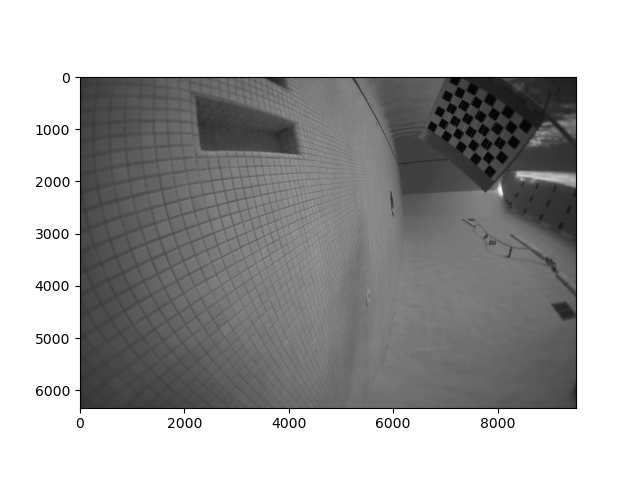

In [29]:
imgfile = '/Users/jasonyuan/Desktop/DSC03365.JPG'
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objpoint = np.zeros((nrows*ncols,3), np.float32)
objpoint[:,:2] = np.mgrid[0:nrows,0:ncols].T.reshape(-1,2)
# Arrays to store object points and image points from all the images.
imgpoint = [] # 2d points in image plane.
img = cv.imread(imgfile)
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

# Find the chess board corners
# ret, corners = cv.findChessboardCorners(gray, (nrows,ncols), None)
# If corners have already been found, load those in and use
im_scaled = cv.resize(img,(img.shape[1]//3,img.shape[0]//3),interpolation=cv.INTER_AREA)
I_new_gray = cv.cvtColor(im_scaled, cv.COLOR_BGR2GRAY)
blurred_gray = cv.bilateralFilter(I_new_gray, 3, 75, 75)

ret,corners = cv.findChessboardCornersSB(blurred_gray,(6,8),cv.CALIB_CB_NORMALIZE_IMAGE + cv.CALIB_CB_ACCURACY)
print(ret)
# If found, add object points, image points (after refining them)
if ret == True:
    corners2 = cv.cornerSubPix(gray, corners*3, (11,11), (-1,-1), criteria)
    imgpoint = np.array(corners2)
    imgpoint = imgpoint.reshape(len(imgpoint),-1)
    %matplotlib notebook
    cv.drawChessboardCorners(gray, (nrows,ncols), corners2, ret)
    plt.imshow(gray, cmap='gray')

# 2. Get corner finding errors

/var/folders/xt/42vcnks11sl1z2hzyp6jhxf00000gn/T/ipykernel_1075/3453775385.py:26: ComplexWarning: Casting complex values to real discards the imaginary part
  eigvals[i]=eigval


<IPython.core.display.Javascript object>


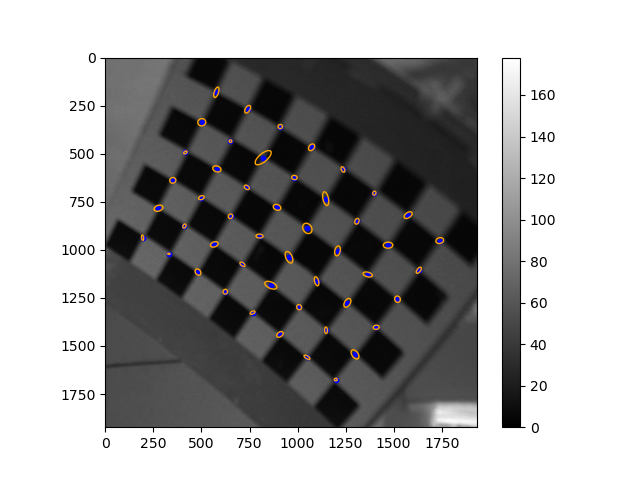

In [34]:
block_size = 4
aperture_size = 3
gray, crop_x1, crop_y1, covs, eigvals, eigvecs = find_all_corner_covs(imgfile, imgpoint, block_size, aperture_size)
%matplotlib notebook
plt.imshow(gray, cmap='gray')
plt.colorbar()
for i in range(len(imgpoint)):
    xid,yid = imgpoint[i][0]-crop_x1, imgpoint[i][1]-crop_y1
    e1 = patches.Ellipse((xid,yid), np.sqrt(eigvals[i][0]), np.sqrt(eigvals[i][1]),
                        angle=np.arctan(eigvecs[i][0][1]/eigvecs[i][0][0])/pi*180, linewidth=1, fill=False, zorder=2, color='orange')
    plt.gca().add_patch(e1)
    plt.scatter(imgpoint[i][0]-crop_x1, imgpoint[i][1]-crop_y1, s=10, marker="o", c='blue')

In [38]:
fig = plt.gcf()
fig.savefig('/Users/jasonyuan/Corner_finding_error.png')